In [24]:
%reload_ext autoreload
%autoreload 2
import pyxdf
import os
import numpy as np
from scipy import stats
from scipy.signal import medfilt, resample
from pathlib import Path
import sys
from datetime import datetime
import pandas as pd
from hampel import hampel
import seaborn as sns
import matplotlib.pyplot as plt
from tueplots import axes, bundles
from astropy.convolution import Gaussian1DKernel, convolve_fft

# Increase the resolution of all the plots below
bundles.beamer_moml()
plt.rcParams.update({"figure.dpi": 200,"figure.facecolor":"w","figure.figsize": (15,10)})


from utilities.utl import find_lsl_stream, find_nearest, fill_nan, axlines_with_text
from utilities.SingleSubjectData import SubjectData, Epochs

In [2]:
# (import) helper functions
dir_script = Path("__file__").parent.absolute()
dir_rawdata = Path.joinpath(dir_script.parent.absolute(), "04_data","00_raw")
dir_plots = Path.joinpath(dir_script.parent.absolute(),"06_plots","01_single_trial")
dir_prep = Path.joinpath(dir_script.parent.absolute(),"04_data","01_prep")
print(dir_script)

c:\Users\User\Desktop\kiel\tremor_feedback_jw\05_scripts


In [3]:
f_list = os.listdir(dir_rawdata)
str_match = 'archer'
fnms = [s for s in f_list if str_match in s]
print([f.split('_')[0] for f in fnms])

['c300', 'c301', 'c302', 'c303', 'c304', 'c305', 'c306', 'c307', 'c308', 'c309', 'c310', 'p200', 'p201', 'p202', 'p203', 'p204', 'p205', 'p206', 'p207', 'p208', 'p209', 'p210', 'p211', 'p212', 'p213', 'p214', 'p215']


In [36]:
# set params for epoch processing and plotting
cfg_gss_plot_colors = plt.cm.viridis(np.linspace(0,1,3))
cfg_trial_times = [0,30]
cfg_trial_times.sort()
cfg_epoch_times =  [0,30]
cfg_epoch_times.sort()

if np.max(cfg_trial_times) > np.diff(cfg_epoch_times):
    raise ValueError ('Time window of interest ouside epoch length')

# prelocate variables
tmp_fnms = fnms
print([f.split('_')[0] for f in tmp_fnms])

id = []
n_trial = []
con_view_ang = []
con_feedback = []
per_bad_samples = []
ppl_size = []



for f in tmp_fnms:
    sub = SubjectData()
    sub.load_data(dir_rawdata,f)

    if not sub.fsr:
        print(f'No GSS data found for {sub.id}')
        continue
        
    # prep raw 
    tmp_dat = medfilt(sub.fsr["time_series"][:,0],3)

    # epoch data
    eps = Epochs(sub,tmp_dat,times=sub.fsr["time_stamps"], events=sub.mrk, srate = sub.srate_ppl)
    eps.srate = 80

    idx_exp_start   = eps.events[eps.events["value"].str.match('block1')].index[0]
    eps.epoch('trial_start*', idx_start=idx_exp_start,tmin=cfg_epoch_times[0],tmax=cfg_epoch_times[1],resample_epochs=True)  

    tmp_view_angle = eps.events["value"][eps.events["value"].str.contains('sfb') ].str.split('_').str[3].astype(float).round(2)


    fig, ax = plt.subplot_mosaic([['main']],
                              constrained_layout=True)
    # prep single trial pupil data
    for i in range(eps.data.shape[2]):

        raw = eps.data[0,:,i]

        if 0 <= i < 4:
            tmp_color = cfg_gss_plot_colors[0]
            tmp_label = 'visual'
        elif 4 <= i < 8:
            tmp_color = cfg_gss_plot_colors[1] 
            tmp_label = 'auditiv-visual'
        elif 8 <= i <12:
            tmp_color = cfg_gss_plot_colors[2]
            tmp_label = 'auditiv'      
           
        id.append(sub.id)
        n_trial.append(i)

        cfg_plot_lw = 1.5
        cfg_epoch_timevec = eps.times

        if tmp_view_angle.iloc[i] == .02:
            ls = 'dotted'
        elif tmp_view_angle.iloc[i] == .44:
            ls = 'solid'

        if i in [0,4,8]:
            ax["main"].plot(cfg_epoch_timevec,raw,color=tmp_color,linewidth=cfg_plot_lw, alpha=.5, linestyle = ls, label=tmp_label)
        else:
            ax["main"].plot(cfg_epoch_timevec,raw,color=tmp_color,linewidth=cfg_plot_lw, alpha=.5, linestyle = ls)


    # info per epoch
    con_view_ang.extend(tmp_view_angle)
    con_feedback.extend(eps.events["value"][eps.events["value"].str.contains('epoch') ].str.split('_').str[1])

    sub_trials = pd.DataFrame()
    sub_trials["feedback_condition"] = con_feedback[-11:]

    axlines_with_text(ax["main"],5, 'Avg. start', axis='x')
    axlines_with_text(ax["main"],25, 'Avg. end', axis='x')
    ax["main"].set_xlabel('Time[s]')
    ax["main"].set_ylabel('Raw force [a.u.]')
    ax["main"].set_title(f"{sub.id} pupil epochs")
    ax["main"].legend(loc = 2) # set legend upper left 
    
    fig.savefig(Path.joinpath(dir_plots,f"{sub.id}_gss_epochs.png"))
    fig.clf()




['c300', 'c301', 'c302', 'c303', 'c304', 'c305', 'c306', 'c307', 'c308', 'c309', 'c310', 'p200', 'p201', 'p202', 'p203', 'p204', 'p205', 'p206', 'p207', 'p208', 'p209', 'p210', 'p211', 'p212', 'p213', 'p214', 'p215']
Max force is 4883 something for c300


C:\Users\User\AppData\Local\Temp\ipykernel_25972\3543607519.py:94: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


Max force is 5894 something for c301


C:\Users\User\AppData\Local\Temp\ipykernel_25972\3543607519.py:94: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


Stream pupil_capture not found
Max force is 6856 something for c302


C:\Users\User\AppData\Local\Temp\ipykernel_25972\3543607519.py:94: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


Max force is 8514 something for c303


C:\Users\User\AppData\Local\Temp\ipykernel_25972\3543607519.py:94: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


Max force is 5598 something for c304


C:\Users\User\AppData\Local\Temp\ipykernel_25972\3543607519.py:94: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


Max force is 8067 something for c305


C:\Users\User\AppData\Local\Temp\ipykernel_25972\3543607519.py:94: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


Max force is 7033 something for c306


C:\Users\User\AppData\Local\Temp\ipykernel_25972\3543607519.py:94: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


Max force is 9657 something for c307


C:\Users\User\AppData\Local\Temp\ipykernel_25972\3543607519.py:94: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


Max force is 12737 something for c308


C:\Users\User\AppData\Local\Temp\ipykernel_25972\3543607519.py:94: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


Max force is 12044 something for c309


C:\Users\User\AppData\Local\Temp\ipykernel_25972\3543607519.py:94: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


Max force is 9064 something for c310


C:\Users\User\AppData\Local\Temp\ipykernel_25972\3543607519.py:94: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


Max force is 15983 something for p200


C:\Users\User\AppData\Local\Temp\ipykernel_25972\3543607519.py:94: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


Max force is 9105 something for p201


C:\Users\User\AppData\Local\Temp\ipykernel_25972\3543607519.py:94: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


Max force is 4625 something for p202


C:\Users\User\AppData\Local\Temp\ipykernel_25972\3543607519.py:94: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


Max force is 7724 something for p203


C:\Users\User\AppData\Local\Temp\ipykernel_25972\3543607519.py:94: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


Max force is 4975 something for p204


C:\Users\User\AppData\Local\Temp\ipykernel_25972\3543607519.py:94: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


Max force is 6563 something for p205


C:\Users\User\AppData\Local\Temp\ipykernel_25972\3543607519.py:94: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


Max force is 7232 something for p206


C:\Users\User\AppData\Local\Temp\ipykernel_25972\3543607519.py:94: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


Max force is 11349 something for p207


C:\Users\User\AppData\Local\Temp\ipykernel_25972\3543607519.py:94: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


Max force is 9584 something for p208


C:\Users\User\AppData\Local\Temp\ipykernel_25972\3543607519.py:94: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


Max force is 6277 something for p209


C:\Users\User\AppData\Local\Temp\ipykernel_25972\3543607519.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplot_mosaic([['main']],
C:\Users\User\AppData\Local\Temp\ipykernel_25972\3543607519.py:94: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


Max force is 12857 something for p210


C:\Users\User\AppData\Local\Temp\ipykernel_25972\3543607519.py:94: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


Max force is 6498 something for p211


C:\Users\User\AppData\Local\Temp\ipykernel_25972\3543607519.py:94: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


Max force is 9859 something for p212


C:\Users\User\AppData\Local\Temp\ipykernel_25972\3543607519.py:94: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


Max force is 10403 something for p213


C:\Users\User\AppData\Local\Temp\ipykernel_25972\3543607519.py:94: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


Max force is 10673 something for p214


C:\Users\User\AppData\Local\Temp\ipykernel_25972\3543607519.py:94: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


Max force is 7632 something for p215


C:\Users\User\AppData\Local\Temp\ipykernel_25972\3543607519.py:94: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

<Figure size 3000x2000 with 0 Axes>

In [33]:
np.nanmin([np.nan,2,4])

2.0

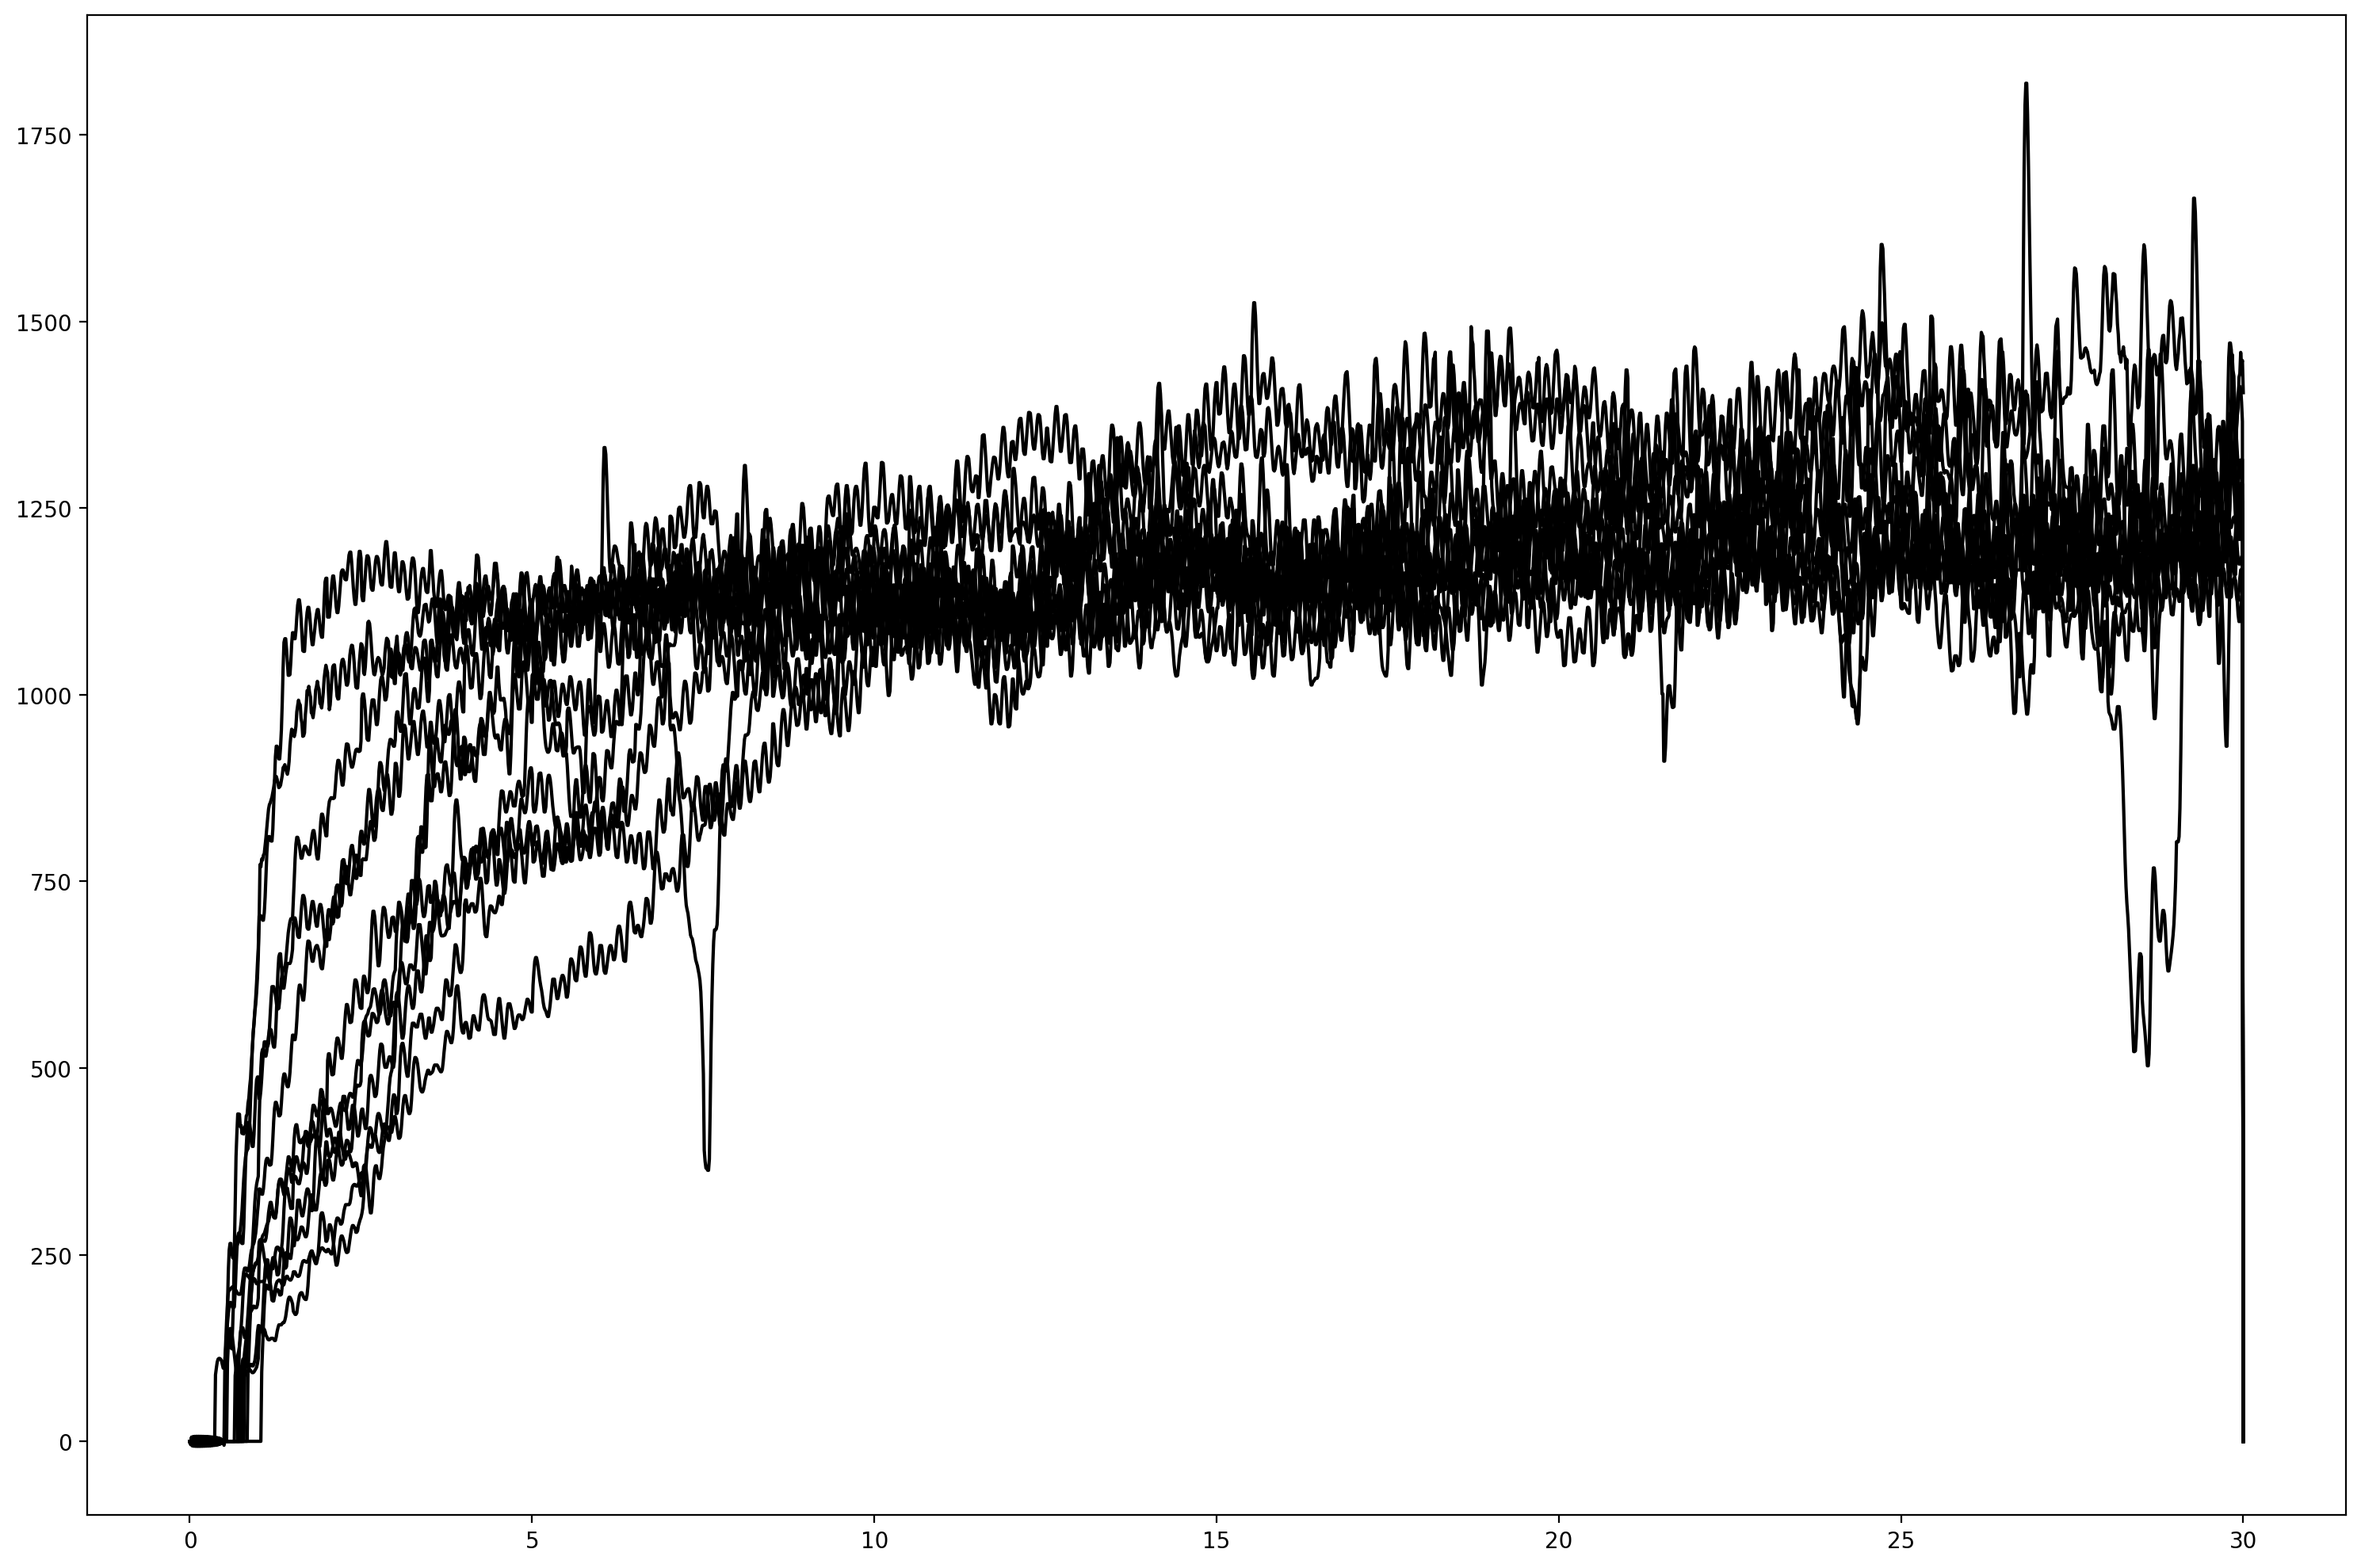

In [17]:
plt.clf()

time_0 = min(min(sub.eye["time_stamps"]),min(sub.fsr["time_stamps"]))
for i in range(eps.data.shape[2]):
    plt.plot(eps.times,eps.data[0,:,i],'k')






In [ ]:
eps.data[0,:,1]

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
all_trials = {"ID": id, "Trial n": n_trial, "Feedback type": con_feedback, "Feedback angle": con_view_ang, "Pupil size": ppl_size, "Percentage bad pupil samples": per_bad_samples}
all_trials = pd.DataFrame(all_trials)

fname = "all_trials_pupil.csv"

all_trials.to_csv(Path.joinpath(dir_prep,fname))


In [ ]:
from scipy.stats import ttest_ind
from scipy import stats
df = all_trials
ppl_z = np.abs(stats.zscore(df['Pupil size']))
df = df[ppl_z <  3]
df_ = df


#define samples
low = df_[df_["Feedback angle"]==0.02]
high = df_[df_["Feedback angle"]==0.44]

#perform independent two sample t-test
t_, p_ = ttest_ind(low['Pupil size'],high['Pupil size'])



Text(0.5, 1.0, 'p:0.002 easy vs. hard')

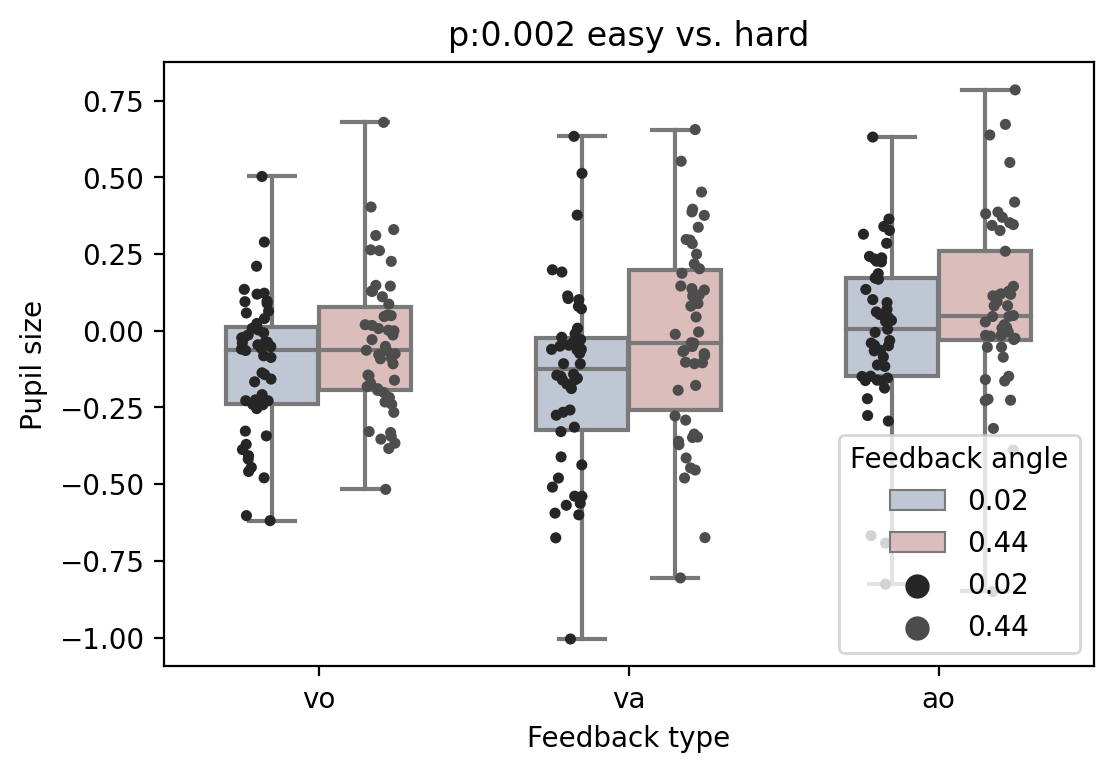

In [ ]:
import seaborn as sns

sns.boxplot(data=df,x="Feedback type",y="Pupil size",hue="Feedback angle",whis=[0, 100], width=.6,palette="vlag")
sns.stripplot(data=df,x="Feedback type",y="Pupil size",hue="Feedback angle",size=4, color=".3", linewidth=0,dodge=True)

plt.title(f"p:{round(p_,3)} easy vs. hard")